In [1]:
import os
os.chdir('../../')

In [2]:
cd = os.getcwd()
functions_path = os.path.join(cd, '02_code/functions')

In [3]:
#import required packages

import scanpy as sc
import scanpy.external as sce
import numpy as np
import pandas as pd
import anndata as ad
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.sparse import csr_matrix
from anndata import AnnData
import skmisc
import regex as re

import anndata2ri
import logging
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro
rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

# from scipy.sparse import csr_matrix
import sys
sys.path.append(functions_path)
import functions_dat_processing as dp
import functions_plotting as dplt

/tmp/ipykernel_1410395/2312776519.py:21: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [16]:
import importlib
importlib.reload(dp)
importlib.reload(dplt)

<module 'functions_plotting' from '/home/s377963/car_t_sc/02_code/functions/functions_plotting.py'>

### Import the preprocessed data

In [5]:
#import data
adata_raw = sc.read_h5ad('./01_data/processed/merged_and_processed/XXXCAR_genome/XXXCAR_genome_raw_demultiplexed.h5ad') 
adata_qc = sc.read_h5ad('./01_data/processed/merged_and_processed/XXXCAR_genome/XXXCAR_genome_after_qc.h5ad')
adata_TIL_only = adata_qc[adata_qc.obs.Location != 'dLN']
adata_pureTC = sc.read_h5ad('./01_data/processed/merged_and_processed/XXXCAR_genome/XXXCAR_genome_after_qc_TIL_only_pure_TC_annotation.h5ad') 
adata_only_pureTC = adata_pureTC[adata_pureTC.obs['is.pure_Tcell'] == 'Pure']
adata_pure_TC_annotated = sc.read_h5ad('./01_data/processed/merged_and_processed/XXXCAR_genome/XXXCAR_genome_after_qc_TIL_only_pure_TC_annotation_non_TC_filtered_TC_subtypes_annotated.h5ad') 
adata_only_annotatedTC = adata_pure_TC_annotated[~adata_pure_TC_annotated.obs['functional.cluster'].isna()]

In [ ]:
#for the data from R
adata = sc.read_h5ad('/home/s377963/car_t_sc/01_data/processed/merged_and_processed/merged_1xintegrated_scaled_pureTCs_annotated_calagry_exact.h5ad') #after annotating TCs and TC subtypes
# adata = sc.read_h5ad('/home/s377963/car_t_sc/01_data/processed/merged_and_processed/merged_1xintegrated_scaled_pureTCs_annotated_pseudocount.h5ad')
# adata = sc.read('./01_data/processed/merged_and_processed/hashsolo_abs_integrated_hvg_TCannotated_TCsubtypes.h5ad')
# adata = sc.read('./01_data/processed/merged_and_processed/hashsolo_mad_soupx_integrated_hvg_TCannotated_TCsubtypes.h5ad')
# adata = sc.read('./01_data/processed/merged_and_processed/hashsolo_mad_integrated_hvg_TCannotated_TCsubtypes.h5ad')
# adata = sc.read('./01_data/processed/merged_and_processed/HTODemux_abs_1000_nosoup.h5ad')

nas = pd.isna(adata.obs['Tcell_subtype'])
adata_nona = adata[~nas,:].copy()
days = ['0', '7', '14']
conditions = ['C', 'DM', 'P']
dplt.add_DaysConds_to_adata(adata_nona, days, conditions)

In [6]:
adatas = [adata_raw, adata_qc, adata_TIL_only, adata_pureTC, adata_only_pureTC, adata_pure_TC_annotated, adata_only_annotatedTC]

In [7]:
for adata in adatas:
    adata.obs.rename(columns={"HTO_classification": "Classification"}, inplace=True) 
    adata.obs.rename(columns={"functional.cluster": "Tcell_subtype"}, inplace=True)
    adata.obs.rename(columns={"pool": "dataset"}, inplace=True)
    rmvd_p = [int(dataset.replace("P", "")) - 1 for dataset in adata.obs['dataset']]
    adata.obs['dataset'] = rmvd_p

/tmp/ipykernel_1410395/3256986173.py:6: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['dataset'] = rmvd_p


In [ ]:
conditions = np.unique(adata.obs.condition.values)
days = sorted(np.unique(adata.obs.day), key=lambda x: int(x), reverse=True)
# Filter for only selected subtype
subtype_only = list(map(lambda subtype: cell_subtype in subtype, adata.obs[obs_column]))
adata = adata[subtype_only, :].copy()
unq_celltypes = np.unique(adata.obs[obs_column])
# Set up subplots for each condition
fig, axs = plt.subplots(len(conditions), figsize=(8, 6)) #, sharey=True
# Plot each condition in a separate subplot
for idx, condition in enumerate(conditions):
    ax = axs[idx] if len(conditions) > 1 else axs  # Handles case with only one condition
    subset = adata[adata.obs.condition == condition, :]
    
    # Initialize dictionary for each celltype's counts by day
    celltype_counts = {celltype: [] for celltype in unq_celltypes}
    
    for celltype in unq_celltypes:
        celltype_subset = subset[subset.obs[obs_column] == celltype, :]
        for day in days:
            day_subset = celltype_subset[celltype_subset.obs.day == day, :]
            day_count = len(day_subset)  # Count the entries for each day and cell type
            celltype_counts[celltype].append(day_count)
    # Normalize cell type counts by day
    norm_factors = [sum(day_counts) for day_counts in zip(*celltype_counts.values())]
    norm_factors = [nf if nf > 0 else 1 for nf in norm_factors] 
    for key, values in celltype_counts.items():
        celltype_counts[key] = (np.array(values) / norm_factors) * 100

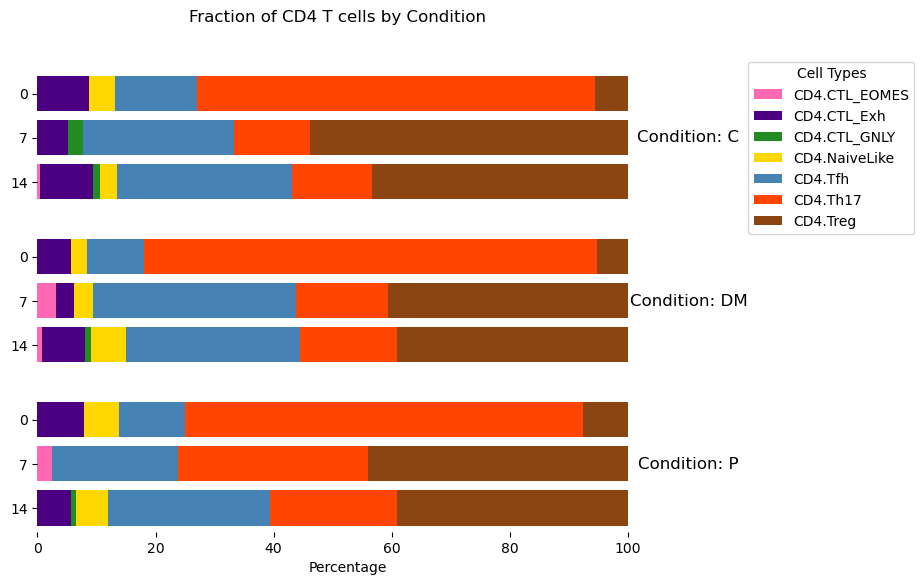

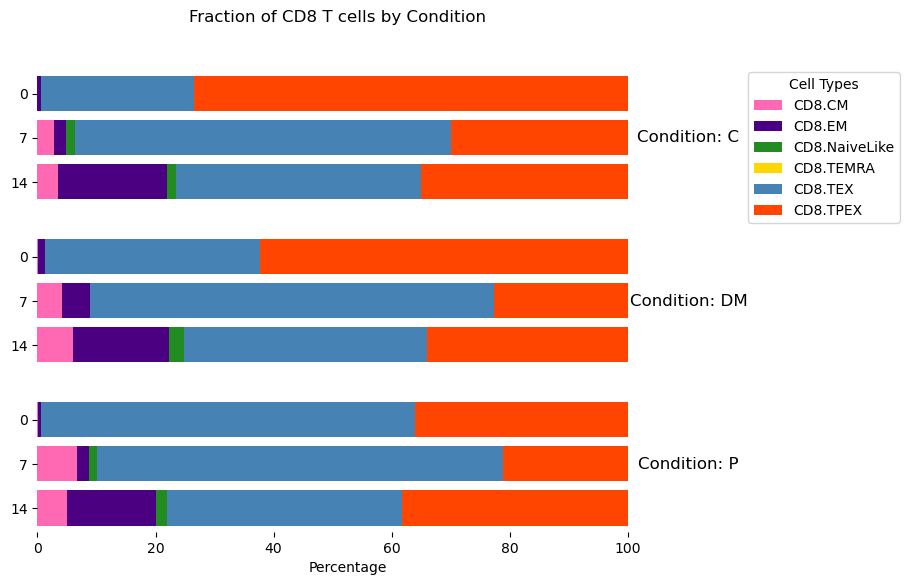

In [7]:
# for the mad filtered hashsolo data
dplt.stacked_barplot(adata_nona, 'CD4', 'Tcell_subtype')
dplt.stacked_barplot(adata_nona, 'CD8', 'Tcell_subtype')

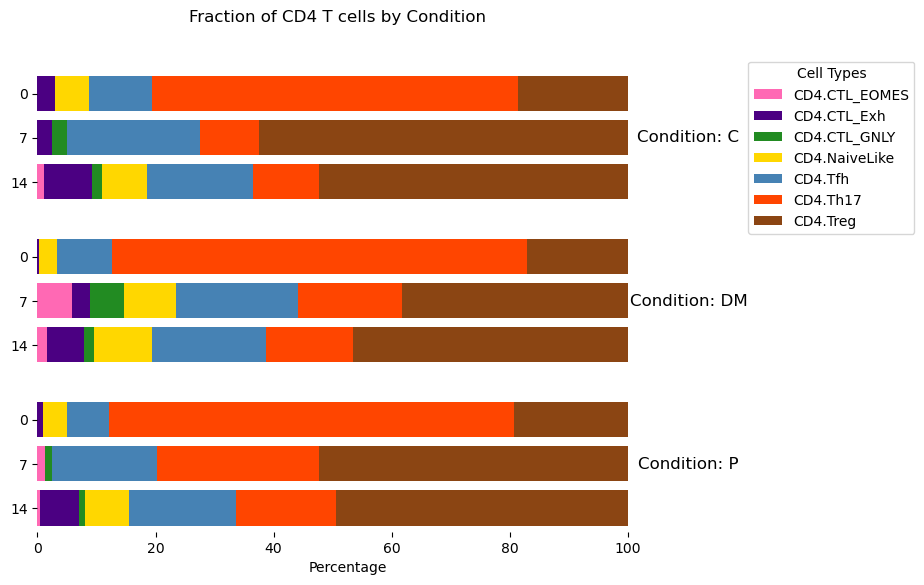

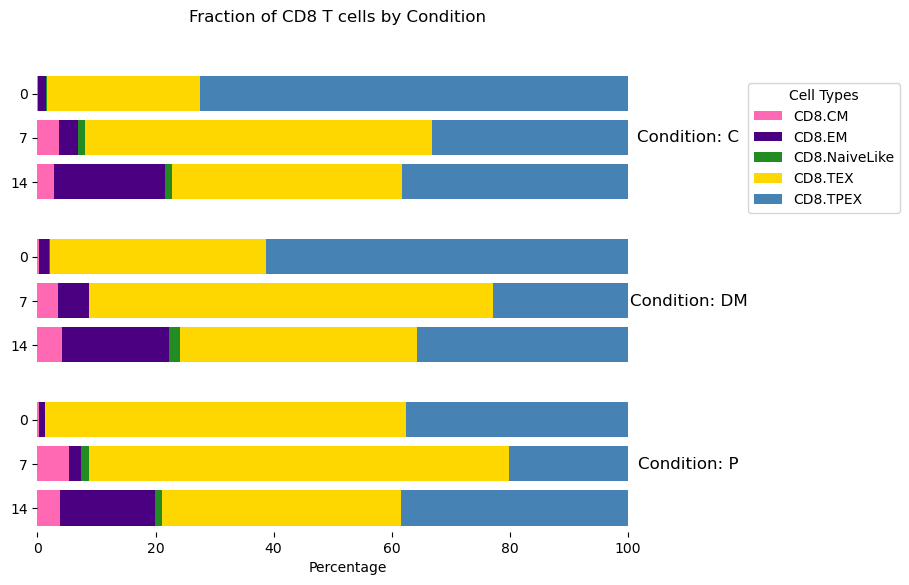

In [24]:
# for the abs filtered hashsolo data not utilising soupX
dplt.stacked_barplot(adata_nona, 'CD4', 'Tcell_subtype')
dplt.stacked_barplot(adata_nona, 'CD8', 'Tcell_subtype')

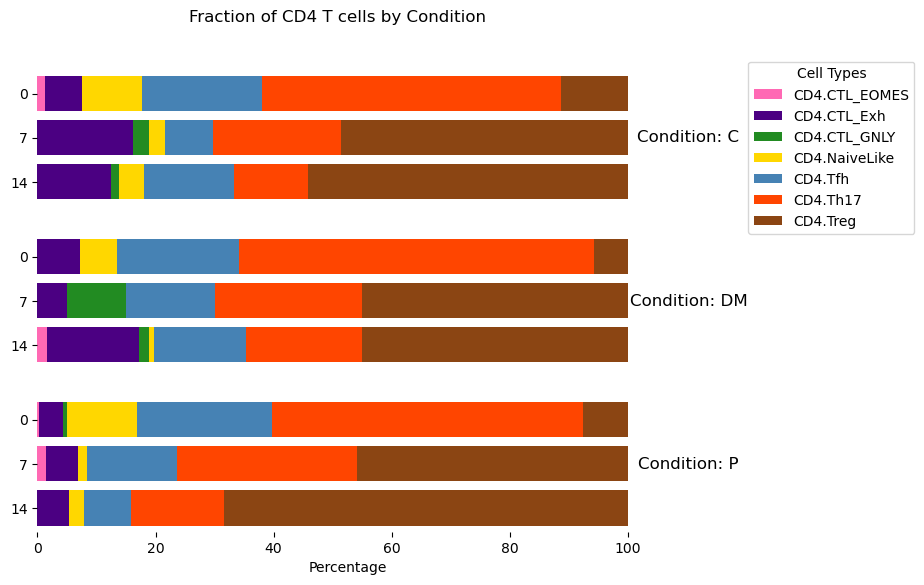

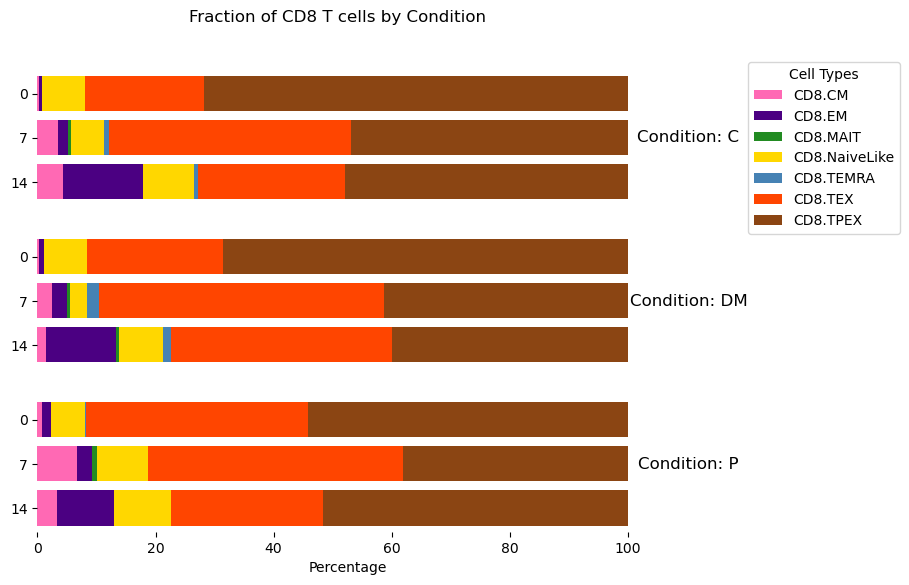

In [17]:
# for the abs filtered HTODemux data utiloizing pseudocounts
dplt.stacked_barplot(adata_nona, 'CD4', 'Tcell_subtype')
dplt.stacked_barplot(adata_nona, 'CD8', 'Tcell_subtype')

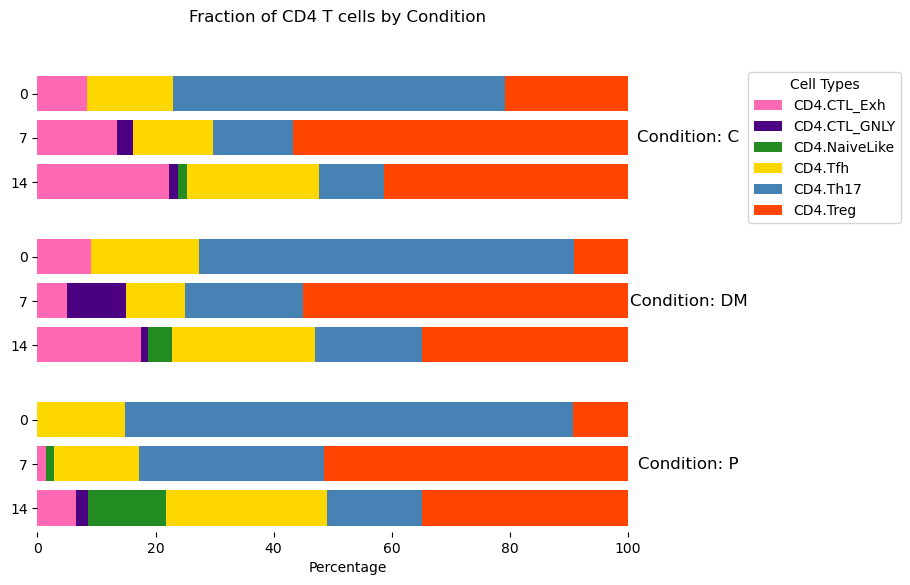

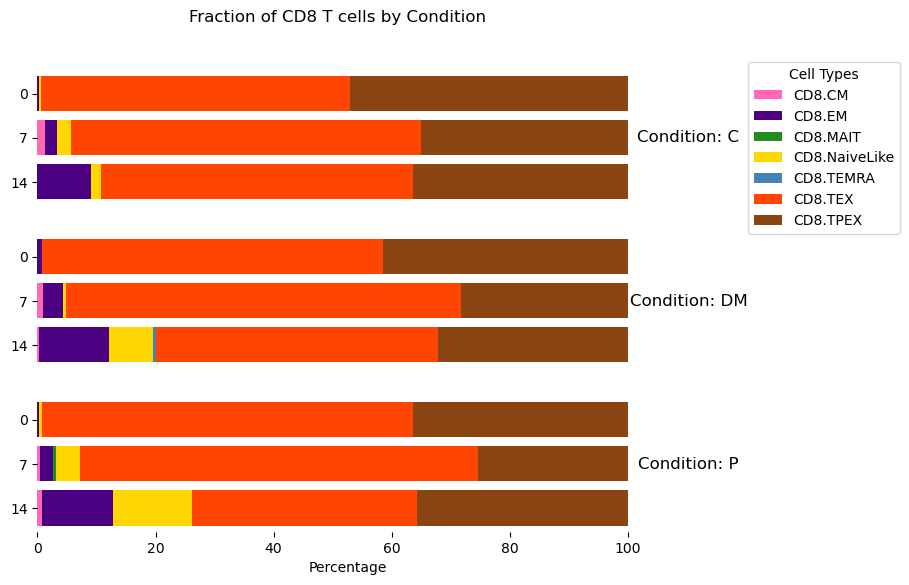

In [9]:
# for the abs filtered HTODemux data (exactly like calagry)
dplt.stacked_barplot(adata_only_annotatedTC, 'CD4', 'Tcell_subtype')
dplt.stacked_barplot(adata_only_annotatedTC, 'CD8', 'Tcell_subtype')

Plot doublets, negatives, singlets from HTODemux

In [8]:
df = adata_raw.obs.copy()
df['dataset'] = df['dataset'] + 1

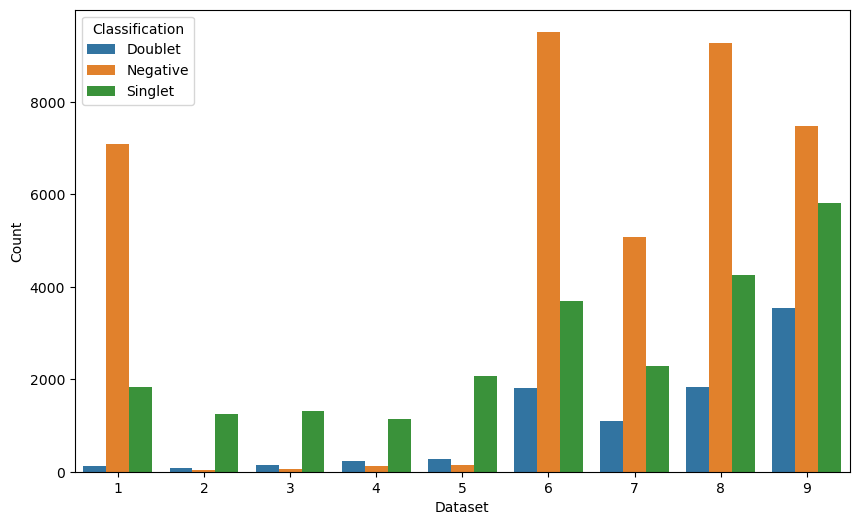

In [9]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x="dataset", hue="HTO_classification.global")

plt.xlabel("Dataset")
plt.ylabel("Count")
# plt.title("Classification Count per Dataset")
plt.legend(title="Classification")
path = './03_results/figures/Preprocessing/htodemux.png'
plt.savefig(path, dpi=300, bbox_inches="tight") 
plt.show()

plot the number of cells eliminated by qc after keeping singlets


In [10]:
#subset raw data to singlets and split into pools
adata_raw_singlets = adata_raw[adata_raw.obs['HTO_classification.global'] == 'Singlet']
adata_raw_singlets_list = [adata_raw_singlets[adata_raw_singlets.obs["dataset"] == d].copy() for d in adata_raw_singlets.obs["dataset"].unique()]
adata_qc_singlets_list = [adata_qc[adata_qc.obs["dataset"] == d].copy() for d in adata_qc.obs["dataset"].unique()]
adatas_singlets_qc = dp.quality_control(adata_qc_singlets_list, method = 'abs')
adatas_raw_singlets_qc = dp.quality_control(adata_raw_singlets_list, method = 'abs')

computing qc for Pool 1
computing qc for Pool 2
computing qc for Pool 3
computing qc for Pool 4
computing qc for Pool 5
computing qc for Pool 6
computing qc for Pool 7
computing qc for Pool 8
computing qc for Pool 9
computing qc for Pool 1
computing qc for Pool 2
computing qc for Pool 3
computing qc for Pool 4
computing qc for Pool 5
computing qc for Pool 6
computing qc for Pool 7
computing qc for Pool 8
computing qc for Pool 9


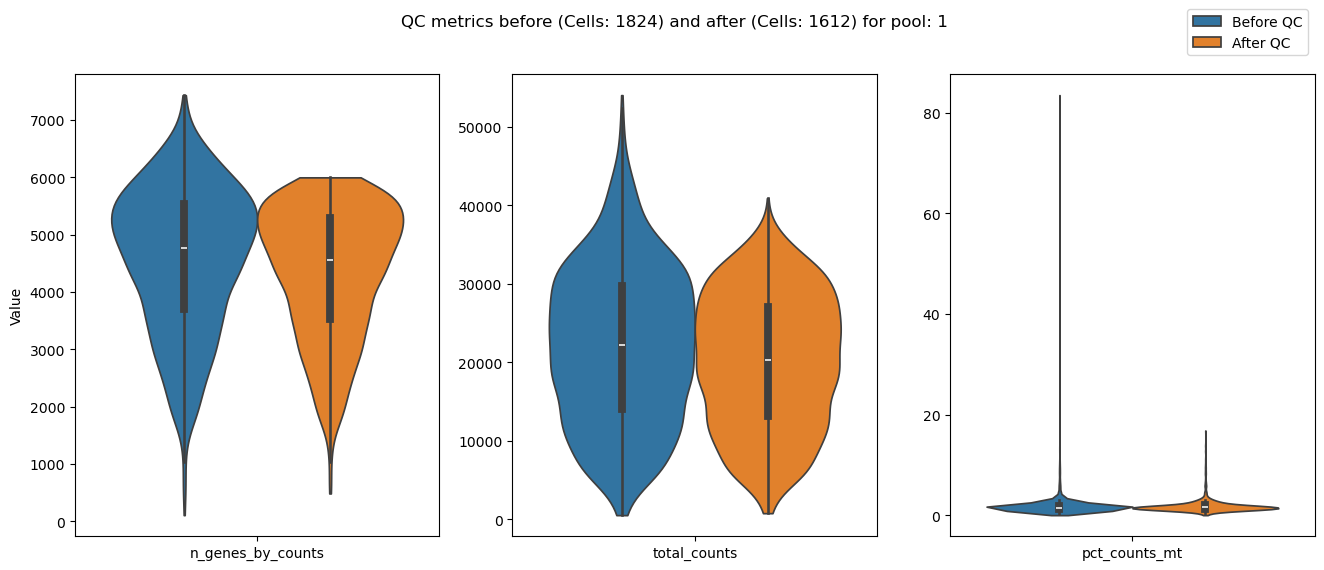

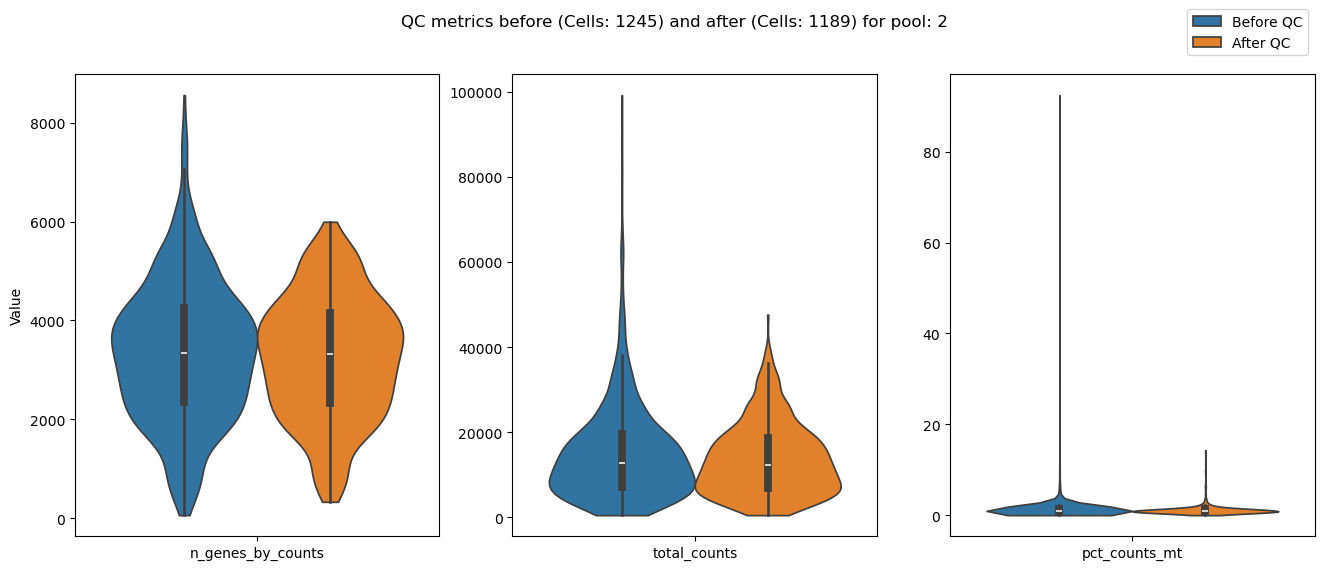

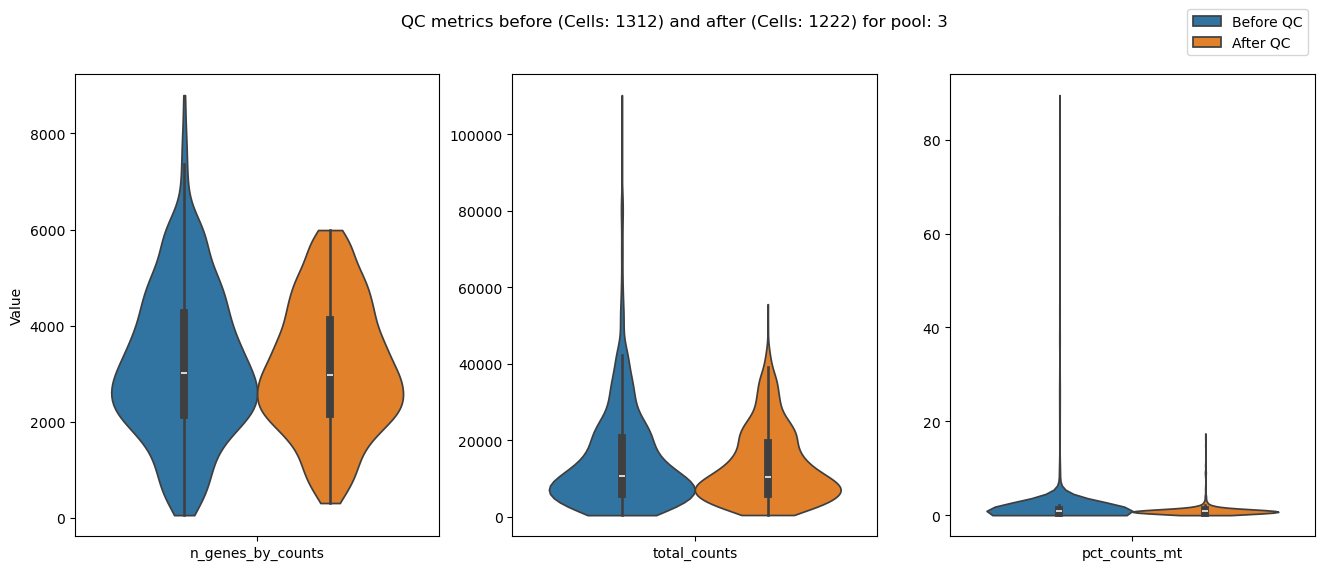

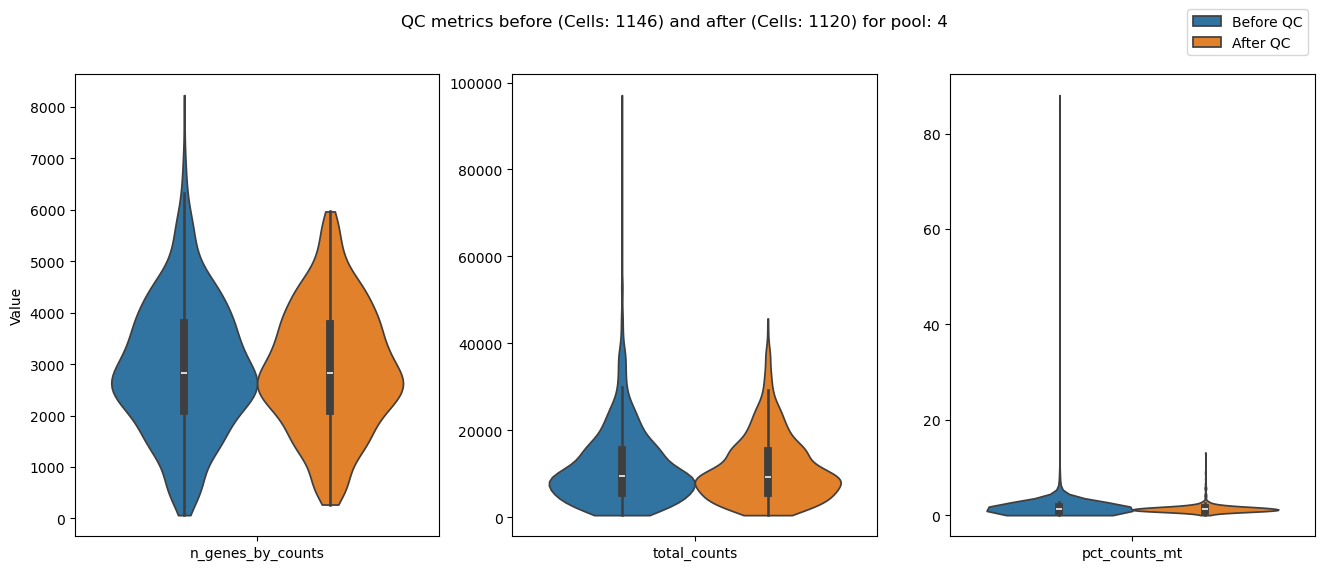

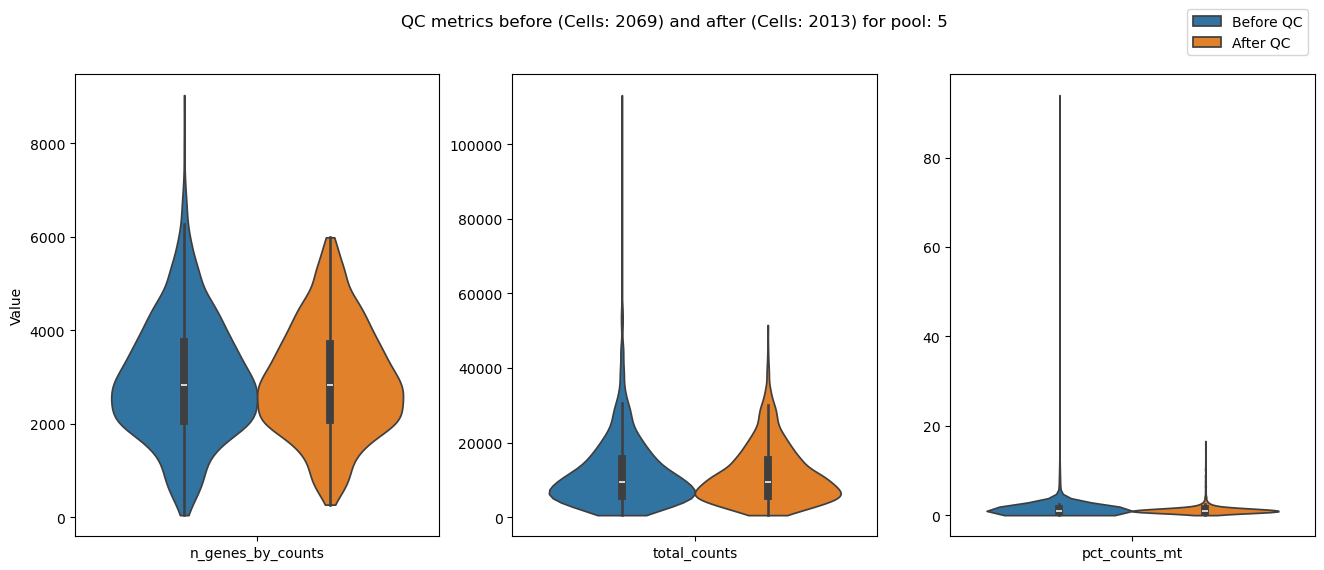

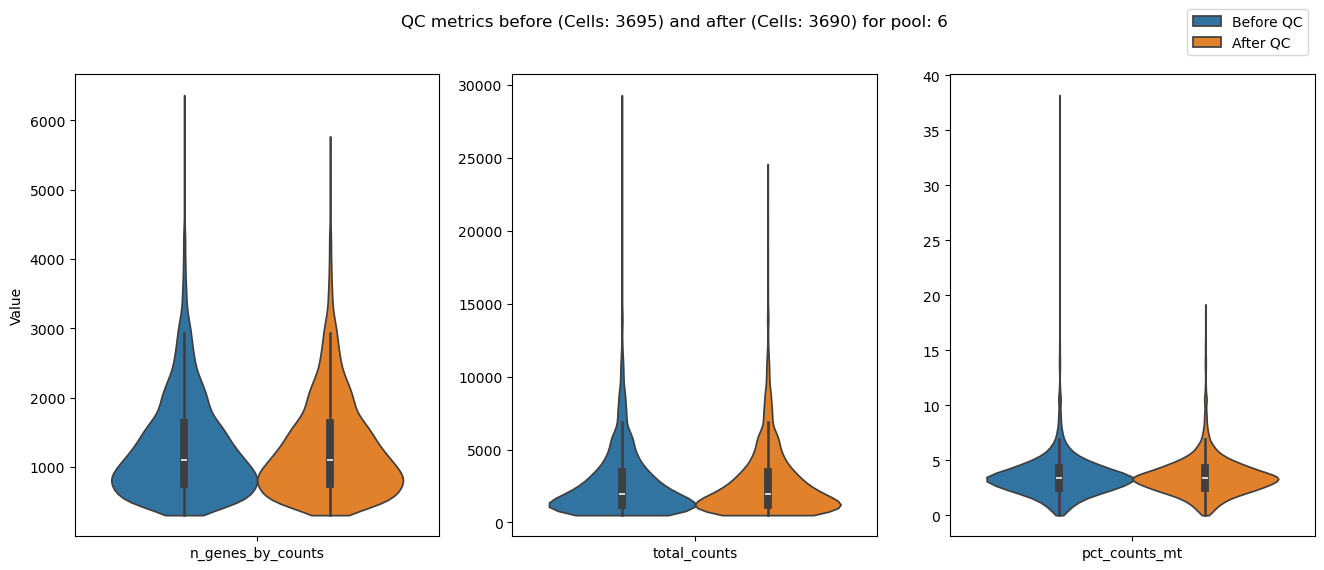

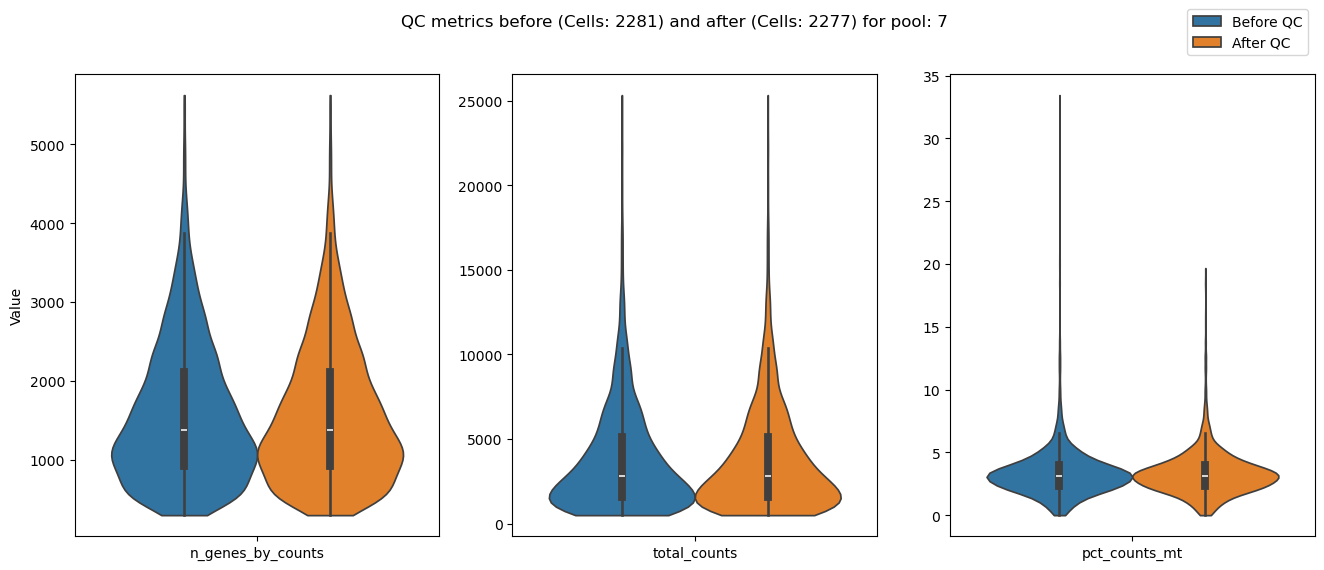

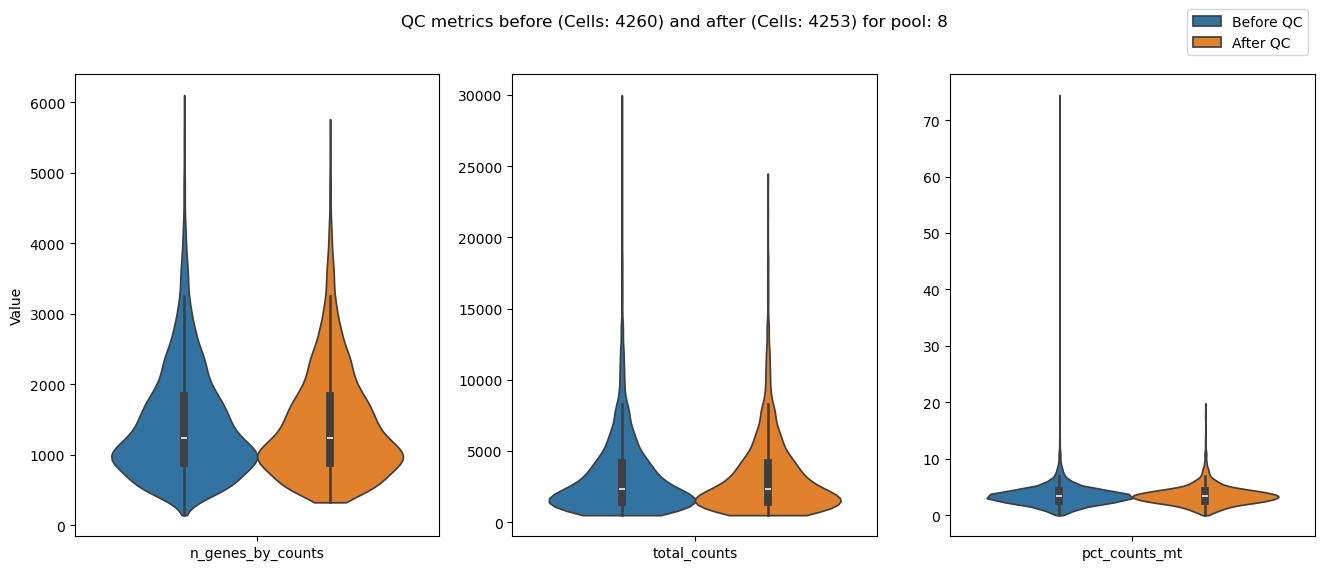

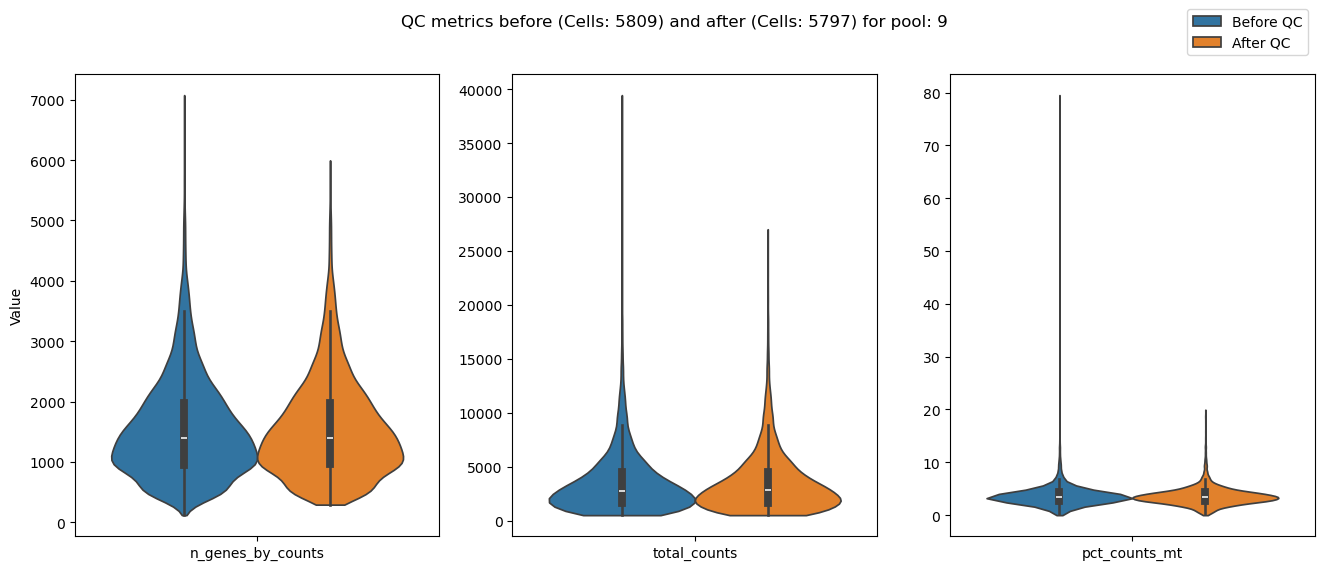

In [14]:
path = './03_results/figures/Preprocessing/'
dp.plot_qc_metrics(adata_raw_singlets_list, adata_qc_singlets_list, save_dir=path)

show how many TILs and dLNs are in each sample respectively

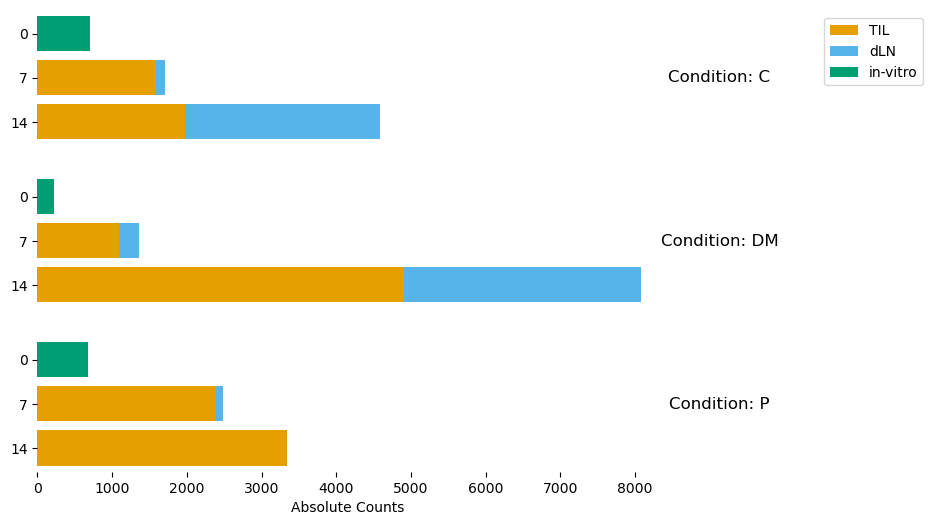

In [17]:
importlib.reload(dplt)
df = dplt.extract_count(adata_qc)
path = './03_results/figures/Preprocessing/dlNvsTIL.png'
dplt.plot_count(df, xmax=8300, save_dir=path)

In [133]:
df = adata_qc.obs.copy()
df['dataset'] = df['dataset'] + 1

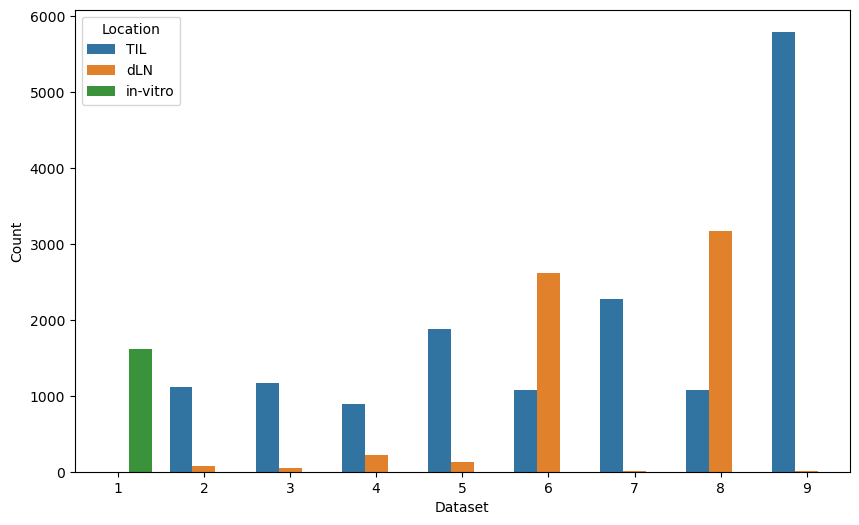

In [135]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x="dataset", hue="Location")
# sns.histplot(data=df, x="condition_day", hue="Location", multiple="stack", discrete=True)

plt.xlabel("Dataset")
plt.ylabel("Count")
# plt.title("Classification Count per Dataset")
plt.legend(title="Location")
plt.show()